In [26]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [27]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [28]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [29]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F_E1(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    return (delta_prime+ws-omega)
    # return X_prime+ws-Y 

def F_E2(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    # return Y_prime
    return omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [30]:
# # Differential equation's exact solution - for comparison
# def X_t(t):
#     # return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)
#     return 0

# def Y_t(t):
#     return 0

In [31]:
t=np.random.uniform(0,1,size=50,requires_grad=False)

In [32]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [33]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [34]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [35]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [36]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     
M0 = 
[5.75089526]
M1 = 
[5.9597548]
M2 = 
[0.07327962]
M3 = 
[5.81537753]


In [37]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):

    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,x)
    return r1

In [38]:
# add the classical layer   #TODO
def classical_quantum_net_efficient(r1,w):
    return w[0]+w[1]*r1+w[2]*r1**2

In [39]:
def classical_quantum_net_prime(theta,w,t):



    r1=quantum_net(theta,t)[0]

    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [40]:
def classical_quantum_net_double_prime(theta,w,t):

   r1=quantum_net(theta,t)[0]
   r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 


   #Calculate double prime
   F_pos_pos_pi = quantum_net(theta,t+np.pi)[0]
   F_phi = quantum_net(theta,t)[0]
   F_phi_neg_pi = quantum_net(theta,t-np.pi)[0]
   r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)


   return w[1]*r1_double_prime+2*w[2]*(r1_prime*r1_prime+r1*r1_double_prime)

In [41]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [42]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [43]:
# def cost(theta1,theta2,w1,w2,t):

#     # loss inner points
#     loss_i = 0

#     X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     Y_t_pred = X_t_pred+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # # loss boundary points
#     # loss_b = 0
#     # X_0_pred = classical_quantum_net(theta1,w1,0)
#     # Y_0_pred = classical_quantum_net(theta2,w2,0)

#     # # print(U_0)
#     # loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     # return 0.2*loss_b + 0.8*loss_i
#     return loss_i

In [44]:
# def cost_efficient(theta1,w1,t):
#     # loss inner points
#     loss_i = 0
#     # print('-------')
#     r1 = np.array([quantum_net(theta1,t)[0] for t in t])

#     # print(r1)

#     r1_prime = np.array([qml.grad(quantum_net,argnum=1)(theta1,np.tensor(t)) for t in t])
#     #Calculate double prime
#     F_pos_pos_pi = np.array([quantum_net(theta1,t+np.pi)[0] for t in t])
#     # print(len(F_pos_pos_pi))
#     F_phi = r1
#     F_phi_neg_pi = np.array([quantum_net(theta1,t-np.pi)[0] for t in t])
#     r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)

#     # print(r1)
#     # print(r1_prime)
#     # print(r1_double_prime)

#     X_t_pred = classical_quantum_net_efficient(r1=theta1,w=w1)
#     X_t_prime = classical_quantum_net_prime_efficient(r1=theta1,r1_prime=r1_prime,w=w1)
    
#     Y_t_pred = X_t_prime+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = classical_quantum_net_double_prime_efficient(r1=theta1,r1_prime=r1_prime,r1_double_prime=r1_double_prime,w=w1)

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # # loss boundary points
#     loss_b = 0
#     X_0_pred = classical_quantum_net(theta1,w1,0)
#     Y_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

#     # # print(U_0)
#     loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     # return loss_b + loss_i
#     return 0.2*loss_b + 0.8*loss_i

    # return loss_i

In [45]:
def cost(theta1,w1,t):

    # loss inner points
    loss_i = 0

    del_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
    del_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
    omega_t_pred = del_t_prime+ws
    # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
    omega_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

    loss_i += np.mean(F_E1(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)

    # # loss boundary points
    loss_b = 0
    del_0_pred = classical_quantum_net(theta1,w1,0)
    omega_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

    # # print(U_0)
    loss_b += (del_0_v-del_0_pred)**2+(omega_0_v-omega_0_pred)**2
    return 2*loss_b + loss_i
    # return 0.2*loss_b + 0.8*loss_i

    return loss_i

In [46]:
w1=np.zeros(3,requires_grad=True)
# w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [47]:
start=now()
print(start)

2023-08-13 21:20:32.481450


In [23]:
epochs=100
cost_max = 10000
theta1_best = None
w1_best = None

for e in range(1,epochs+1):

    # (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    (theta1,w1,_),_cost=opt.step_and_cost(cost,theta1,w1,t)

    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        w1_best = w1

    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')



Epoch: 1 | Cost: 1.249999999999988
Epoch: 2 | Cost: 0.9940899615391253
Epoch: 3 | Cost: 1.0676948647079043
Epoch: 4 | Cost: 1.0670804340172224
Epoch: 5 | Cost: 1.0087076174172667
Epoch: 6 | Cost: 0.9351188230666149
Epoch: 7 | Cost: 0.9312376575719071
Epoch: 8 | Cost: 0.9312208996802578
Epoch: 9 | Cost: 0.8624541687839414
Epoch: 10 | Cost: 0.7912655910593391
Epoch: 11 | Cost: 0.7716638793851059
Epoch: 12 | Cost: 0.7536245465249056
Epoch: 13 | Cost: 0.7051312532039896
Epoch: 14 | Cost: 0.6353395290685143
Epoch: 15 | Cost: 0.5766587034777554
Epoch: 16 | Cost: 0.5532337807567259
Epoch: 17 | Cost: 0.5160486125845173
Epoch: 18 | Cost: 0.45715010332719136
Epoch: 19 | Cost: 0.4079910285674651
Epoch: 20 | Cost: 0.37217694874138646
Epoch: 21 | Cost: 0.34378702690041335
Epoch: 22 | Cost: 0.3167557102949481
Epoch: 23 | Cost: 0.27813320543756825
Epoch: 24 | Cost: 0.23617923473426689
Epoch: 25 | Cost: 0.21507029957254536
Epoch: 26 | Cost: 0.2057882099807129
Epoch: 27 | Cost: 0.18759468540003893
Epoc

In [48]:
# np.save('theta.npy', theta1)
# np.save('w.npy',w1)

In [75]:
# print(_cost)
t=np.random.uniform(0,1,size=100,requires_grad=False)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=(np.array([classical_quantum_net_prime(theta1,w1,t) for t in t])+ws)
print(pred_train_X)
print(pred_train_Y)
# pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911 37.69911
 37.69911 37.69911 37.69911 37.69911 

In [72]:
t_real = [0.0, 0.010101010101010102, 0.020202020202020204, 0.030303030303030304, 0.04040404040404041, 0.050505050505050504, 0.06060606060606061, 0.0707070707070707, 0.08080808080808081, 0.09090909090909091, 0.10101010101010101, 0.1111111111111111, 0.12121212121212122, 0.13131313131313133, 0.1414141414141414, 0.15151515151515152, 0.16161616161616163, 0.1717171717171717, 0.18181818181818182, 0.1919191919191919, 0.20202020202020202, 0.21212121212121213, 0.2222222222222222, 0.23232323232323232, 0.24242424242424243, 0.25252525252525254, 0.26262626262626265, 0.2727272727272727, 0.2828282828282828, 0.29292929292929293, 0.30303030303030304, 0.31313131313131315, 0.32323232323232326, 0.3333333333333333, 0.3434343434343434, 0.35353535353535354, 0.36363636363636365, 0.37373737373737376, 0.3838383838383838, 0.3939393939393939, 0.40404040404040403, 0.41414141414141414, 0.42424242424242425, 0.43434343434343436, 0.4444444444444444, 0.45454545454545453, 0.46464646464646464, 0.47474747474747475, 0.48484848484848486, 0.494949494949495, 0.5050505050505051, 0.5151515151515151, 0.5252525252525253, 0.5353535353535354, 0.5454545454545454, 0.5555555555555556, 0.5656565656565656, 0.5757575757575758, 0.5858585858585859, 0.5959595959595959, 0.6060606060606061, 0.6161616161616161, 0.6262626262626263, 0.6363636363636364, 0.6464646464646465, 0.6565656565656566, 0.6666666666666666, 0.6767676767676768, 0.6868686868686869, 0.696969696969697, 0.7070707070707071, 0.7171717171717171, 0.7272727272727273, 0.7373737373737373, 0.7474747474747475, 0.7575757575757576, 0.7676767676767676, 0.7777777777777778, 0.7878787878787878, 0.797979797979798, 0.8080808080808081, 0.8181818181818182, 0.8282828282828283, 0.8383838383838383, 0.8484848484848485, 0.8585858585858586, 0.8686868686868687, 0.8787878787878788, 0.8888888888888888, 0.898989898989899, 0.9090909090909091, 0.9191919191919192, 0.9292929292929293, 0.9393939393939394, 0.9494949494949495, 0.9595959595959596, 0.9696969696969697, 0.9797979797979798, 0.98989898989899, 1.0]
y_delta_real = [-0.1, -0.09292223980963361, -0.08583339672681049, -0.07873819373865806, -0.07164160445474957, -0.0645488531071044, -0.05746541455018758, -0.05039701426090967, -0.043349533900744155, -0.036328957825746, -0.029341472379610736, -0.02239321114539309, -0.015490248233323282, -0.008638598280807519, -0.0018442164524273836, 0.004887001560059611, 0.01154922233269212, 0.018136900532249138, 0.024644735308884922, 0.031067641551267226, 0.03740084123776386, 0.043639863436442806, 0.04978054430507171, 0.05581902709111886, 0.06175176213175188, 0.06757550685383919, 0.07328727803726343, 0.07888444349316515, 0.08436505223258099, 0.08972744766816508, 0.09497023731675054, 0.10009229279934921, 0.10509274984115201, 0.1099710082715285, 0.11472673202402761, 0.11935984913637677, 0.12387055175048226, 0.12825929611242956, 0.13252680257248262, 0.13667405558508483, 0.14070225462039962, 0.14461255802513015, 0.14840650741940042, 0.15208577066768617, 0.15565208077446424, 0.1591072358842128, 0.162453099281411, 0.16569159939053923, 0.16882472977607915, 0.17185454914251347, 0.17478318133432622, 0.1776128153360024, 0.18034570527202837, 0.18298417040689188, 0.18553059514508116, 0.18798740609600895, 0.19035689253909124, 0.1926412487256223, 0.1948426428976642, 0.19696321745865517, 0.19900508897340943, 0.20097034816811724, 0.2028610599303449, 0.20467926330903477, 0.20642697151450523, 0.2081061719184507, 0.2097188260539417, 0.2112668696154247, 0.2127522124587222, 0.21417673860103298, 0.21554230622093148, 0.21685074765836848, 0.21810386941467055, 0.21930345215254063, 0.22045125069605762, 0.2215489922950026, 0.22259818719507857, 0.22360015145726256, 0.22455620704570456, 0.22546764648921294, 0.22633573288125447, 0.22716169987995435, 0.2279467517080962, 0.22869206315312202, 0.22939877956713223, 0.23006801686688563, 0.2307008615337995, 0.23129837061394948, 0.23186157171806962, 0.23239146302155236, 0.23288901326444864, 0.23335516175146767, 0.23379081835197718, 0.23419686350000327, 0.23457414819423045, 0.23492349399800166, 0.23524569257559022, 0.23554131782942336, 0.2358109020781764, 0.23605508170803655]
y_omega_real = [38.39911, 38.400428270926156, 38.401299655130565, 38.40169168552899, 38.401575422949456, 38.40092545613228, 38.399719901730016, 38.39794040430749, 38.395572352037746, 38.39260565425085, 38.3890342397665, 38.3848559990875, 38.38007279032815, 38.37469043921426, 38.36871873908312, 38.36217145088351, 38.35506626910548, 38.347422801420755, 38.3392647705979, 38.330618794006334, 38.32151287957913, 38.311976425813015, 38.30204022176835, 38.29173644706917, 38.28109867190314, 38.27016185702156, 38.258961321209455, 38.2475297742564, 38.23590217012037, 38.22411246939691, 38.212193246972774, 38.20017569202592, 38.18808960802549, 38.17596341273183, 38.163824138196475, 38.15169743076215, 38.139607551062795, 38.127577374023524, 38.11562838886067, 38.10378069908174, 38.09205300010923, 38.08046148848102, 38.069019627397445, 38.057739666933706, 38.046632748173664, 38.035708903209844, 38.024977055143445, 38.01444501808432, 38.004119497151, 37.9940060884707, 37.98410927917925, 37.97443244742121, 37.964977862349755, 37.95574668412676, 37.946738963922755, 37.93795452037391, 37.92939393309099, 37.92105522519051, 37.91293608752996, 37.90503402314169, 37.897346347232876, 37.88987018718551, 37.88260248255641, 37.87553998507722, 37.86867925865441, 37.86201667936928, 37.85554843547796, 37.84927052741138, 37.84317876777532, 37.83726878135038, 37.83153600509199, 37.8259756881304, 37.82058289177068, 37.815352489492724, 37.81027916695127, 37.80535743544502, 37.8005828618055, 37.795951468161256, 37.791458900722056, 37.787100858996574, 37.782873095792326, 37.77877141721569, 37.774791682671896, 37.77092980486505, 37.76718174979811, 37.76354353677291, 37.76001123839011, 37.75658098054927, 37.75324894244879, 37.75001135658593, 37.746864508756815, 37.743804738056426, 37.740828436878616, 37.73793205091609, 37.735112079160416, 37.732365073902024, 37.72968764237787, 37.72707713113195, 37.724531053696595, 37.7220465421391]
print(len(t_real))
print(len(y_delta_real))
print(len(y_omega_real))
print(len(t))

100
100
100
100


In [73]:
print(len(pred_train_X))

100


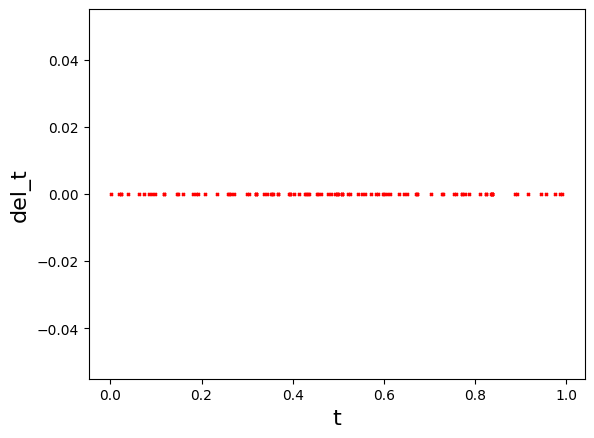

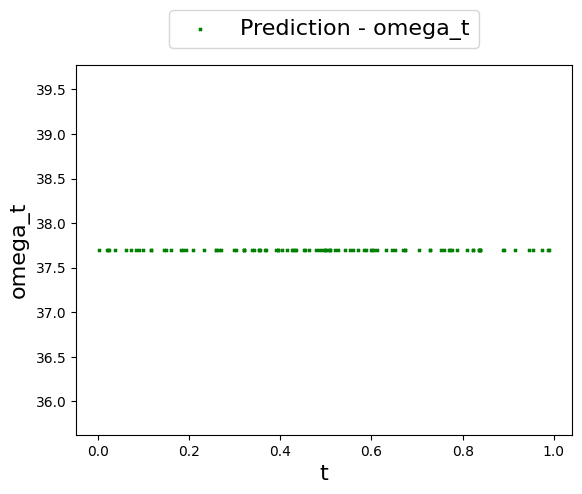

In [74]:
plt.figure()
# plt.scatter(t_real,y_delta_real,facecolors='none', edgecolors='r', label='True - X_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)
plt.figure()
plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - omega_t')
# plt.scatter(t_real,y_omega_real,facecolors='none', edgecolors='g', label='True - Y_t')

plt.xlabel('t',fontsize=16)
plt.ylabel('omega_t',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()